# Supervised Machine Learning - Decision Tree

In [1]:
import pandas as pd
import numpy as np

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import pydotplus
import imageio,io

import os 
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

# Confusion Matrix
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

In [2]:
# Reading csv files
games_women = pd.read_csv('athletes-women.csv')
games_men = pd.read_csv('athletes-men.csv')
athletes = pd.read_csv('athletes-all.csv')

# athletes who made it into the games
games_all = pd.concat([games_women, games_men])
games_women = games_women.drop(columns = ['rank', 'latitude', 'longitude', 'name', 'region'])
games_men = games_men.drop(columns = ['rank', 'latitude', 'longitude', 'name', 'region'])

/Users/allisontao/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df = athletes.merge(games_all.drop_duplicates(), on=['athlete_id'],
                   how='left', indicator=True)

In [4]:
# taking only the columns we want
df_all = df[['athlete_id', 'age_x', 'gender', 'height_x', 'weight_x', 'fran_x', 'run5k_x', 'pullups_x', '_merge', 'train', 'experience', 'schedule', 'howlong_x', 'run400_x', 'candj_x', 'snatch_x', 'deadlift_x', 'backsq_x']]
df_all = df_all.dropna()

df_all_men = df_all.loc[df_all['gender'] == 'Male']

In [5]:
# ones who have not made it who have stats filled out, temp while cleaning up
def make_columns_numeric(df):    
    not_make = df.loc[df['_merge'] == 'left_only']
    not_make['howlong_x'] = not_make['howlong_x'].str.slice(0, 6)

    col         = 'howlong_x'
    conditions  = [ not_make[col].str.contains("Less"), not_make[col].str.contains("6-12"), not_make[col].str.contains("1-2"), not_make[col].str.contains("2-4"), not_make[col].str.contains("4+") ]
    choices     = [0,1,2,3,4]

    not_make["howlong"] = np.select(conditions, choices)

    not_make['coach'] = np.where(not_make['train'].str.contains("have a coach"), 1, 0)
    not_make['certification'] = np.where(not_make['experience'].str.contains("Level 1"), 1, 0)
    not_make['multiple'] = np.where(not_make['schedule'].str.contains("multiple workouts"), 1, 0)

    return not_make

not_make_men = make_columns_numeric(df_all_men)

<ipython-input-5-6b737b4a4228>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_make['howlong_x'] = not_make['howlong_x'].str.slice(0, 6)
<ipython-input-5-6b737b4a4228>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_make["howlong"] = np.select(conditions, choices)
<ipython-input-5-6b737b4a4228>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [8]:
#not_in_games will contain all athletes that did not make it, with stats, with cleaned up columns
not_in_games_men = not_make_men[['athlete_id', 'age_x', 'height_x', 'weight_x', 'fran_x', 'run5k_x', 'pullups_x', 'run400_x', 'candj_x', 'snatch_x', 'deadlift_x', 'backsq_x','howlong','coach','certification','multiple']]
not_in_games_men.rename(columns={"age_x": "age",'height_x': 'height', 'weight_x':'weight', 'fran_x':'fran', 'run5k_x':'run5k','pullups_x':'pullups', 'run400_x':'run400', 'candj_x':'candj', 'snatch_x':'snatch', 'deadlift_x':'deadlift', 'backsq_x':'backsq'}, inplace = True)

/Users/allisontao/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [9]:
#Min and Max of men
not_in_games_men2 = not_in_games_men.loc[(not_in_games_men["height"] <= 100) & (not_in_games_men["height"] >= 50) & (not_in_games_men["weight"] <= 300) & (not_in_games_men["weight"] >= 100) &(not_in_games_men["fran"] <= 600) & (not_in_games_men["fran"] >= 113) & (not_in_games_men["run400"] <= 180) & (not_in_games_men["run5k"] <= 3600) & (not_in_games_men["pullups"] <= 100) &(not_in_games_men["backsq"] <= 1157) &(not_in_games_men["deadlift"] <= 1105)]
not_in_games_men2.agg([min, max])

,athlete_id,age,height,weight,fran,run5k,pullups,run400,candj,snatch,deadlift,backsq,howlong,coach,certification,multiple
min,86.0,14.0,55.0,101.0,115.0,60.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0,0
max,623866.0,56.0,82.0,300.0,600.0,3562.0,100.0,180.0,428.0,500.0,717.0,675.0,4,1,1,1


In [10]:
games_men['in_games'] = 1
not_in_games_men2['in_games'] = 0

<ipython-input-10-0ae7fbd47e18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_in_games_men2['in_games'] = 0


In [11]:
df_men = not_in_games_men2.append(games_men)

# Drop ID column
df_men = df_men.drop(['athlete_id'],axis=1)

In [12]:
pos_tempo = df_men[df_men['in_games']== 1]['age']
neg_tempo = df_men[df_men['in_games']== 0]['age']
pos_tempo = df_men[df_men['in_games']== 1]['height']
neg_tempo = df_men[df_men['in_games']== 0]['height']
pos_tempo = df_men[df_men['in_games']== 1]['weight']
neg_tempo = df_men[df_men['in_games']== 0]['weight']
pos_tempo = df_men[df_men['in_games']== 1]['fran']
neg_tempo = df_men[df_men['in_games']== 0]['fran']
pos_tempo = df_men[df_men['in_games']== 1]['run5k']
neg_tempo = df_men[df_men['in_games']== 0]['run5k']
pos_tempo = df_men[df_men['in_games']== 1]['pullups']
neg_tempo = df_men[df_men['in_games']== 0]['pullups']
pos_tempo = df_men[df_men['in_games']== 1]['run400']
neg_tempo = df_men[df_men['in_games']== 0]['run400']
pos_tempo = df_men[df_men['in_games']== 1]['candj']
neg_tempo = df_men[df_men['in_games']== 0]['candj']
pos_tempo = df_men[df_men['in_games']== 1]['snatch']
neg_tempo = df_men[df_men['in_games']== 0]['snatch']
pos_tempo = df_men[df_men['in_games']== 1]['deadlift']
neg_tempo = df_men[df_men['in_games']== 0]['deadlift']
pos_tempo = df_men[df_men['in_games']== 1]['backsq']
neg_tempo = df_men[df_men['in_games']== 0]['backsq']

In [15]:
train, test = train_test_split(df_men,test_size=0.15)

In [16]:
c = DecisionTreeClassifier(min_samples_split=100)

In [17]:
features = ['age', 'height', 'weight', 'fran', 'run5k', 'pullups', 'run400', 'candj', 'snatch', 'deadlift', 'backsq']

In [18]:
X_train = train[features]
y_train = train['in_games']

X_test = test[features]
y_test = test['in_games']

In [19]:
c.fit(X_train,y_train)

DecisionTreeClassifier(min_samples_split=100)

In [20]:
def show_tree(tree,features,path):
  f = io.StringIO()
  export_graphviz(tree,out_file=f,feature_names=features)
  pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
  img = imageio.imread(path)
  plt.rcParams['figure.figsize'] = (20,20)
  plt.imshow(img)

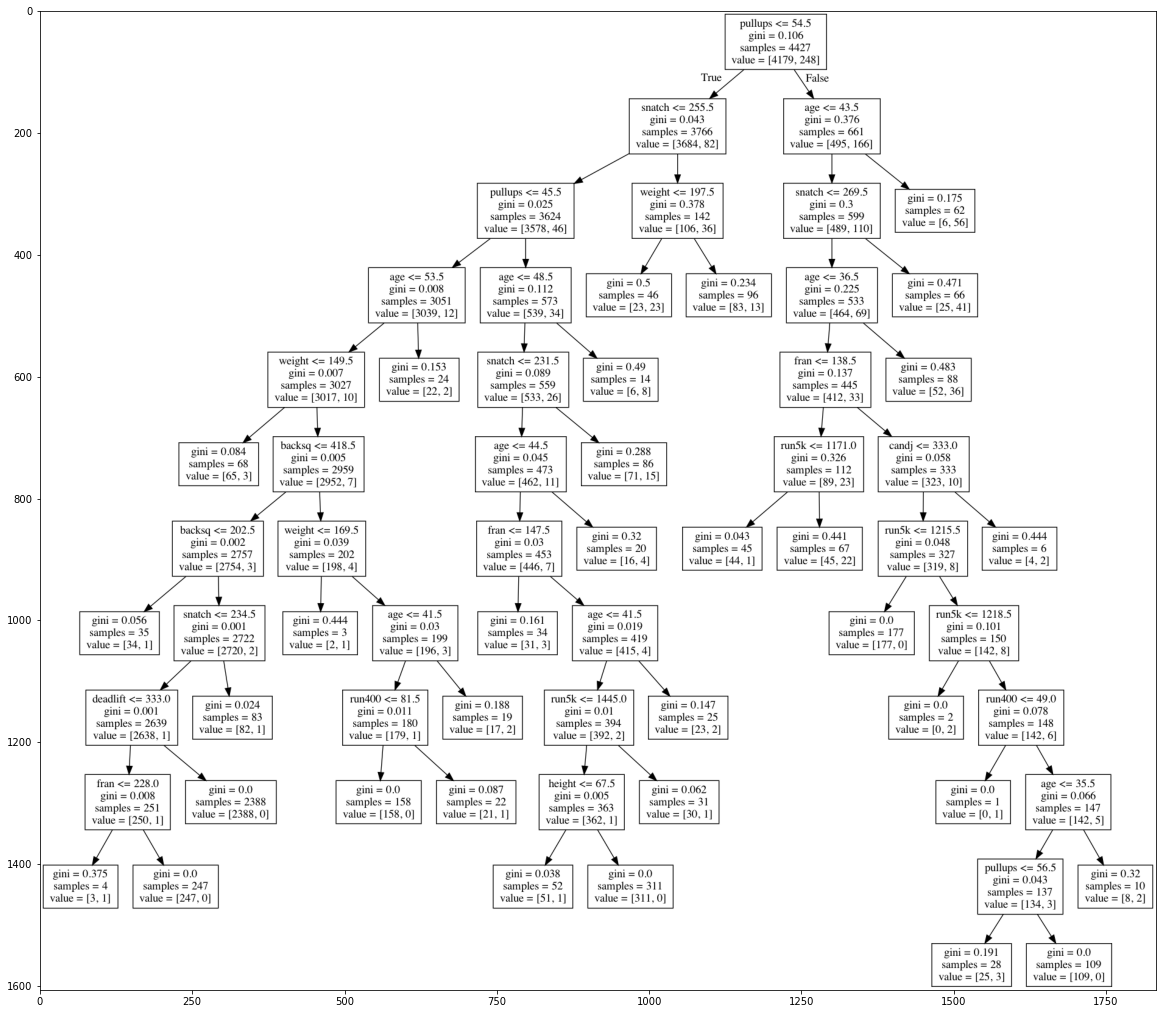

In [21]:
show_tree(c,features,'decision_tree')

In [22]:
y_pred = c.predict(X_test)

In [23]:
score = accuracy_score(y_test,y_pred)*100

NameError: name 'accuracy_score' is not defined

In [ ]:
print("Accuracy using Decision Tree: ",score )

In [24]:
def confusion_matrix(y, y_pred):
    cm = sk_confusion_matrix(y, y_pred)
    cm = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
    cm.columns.name = 'Predicted label'
    cm.index.name = 'True label'
    error_rate = (y_pred != y).mean()
    print('error rate: %.2f' % error_rate)
    return cm

confusion_matrix(y_test, y_pred)

error rate: 0.05


Predicted label,0,1
True label,,
0,729,15
1,22,16
